# feature analysis result - already exist in the previous result file

We use WL or CCA to do the
1. inter-subject gesture classification
2. Few-shot adaptation

WL로 가자

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, random
sys.path.append('../../Shared')
import processing, Model, Visualization, modules, Adaptation
from sklearn.model_selection import train_test_split



def import_data(subject, current_rep, db_name, feat_idx):
    path = f'C:/Users/hml76/Desktop/UMN/Research/5th Federated Prototype Learning/Dataset/{db_name}/'

    x_train = np.array(pd.read_csv(path + 'Sub{}/Sub{}_Rep{}_data.csv'.format(subject, subject, current_rep)))
    y_train = np.array(pd.read_csv(path + 'Sub{}/Sub{}_Rep{}_label.csv'.format(subject, subject, current_rep)))
    indices = np.random.permutation(len(x_train)) #shuffle
    x_train, y_train = x_train[indices], y_train[indices]

    x_train = x_train.reshape(len(x_train), 12, 11)
    x_train = x_train[:, :, feat_idx]
    x_train = x_train.reshape(len(x_train), 12, 1)

    return x_train, y_train

def ready_data_per_subject_all_reps(subject, Data, downsample, downsample_size, feat_idx):
    X, y = [], []
    for rep in range(1,7):
        X_tmp, y_tmp = import_data(subject, rep, Data, feat_idx)

        X.append(X_tmp)
        y.append(y_tmp)
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    y = np.array([np.argmax(y[i]) for i in range(len(y))])

    if downsample:
        idx = np.random.choice(X.shape[0], size=downsample_size, replace=False)
        X, y = X[idx], y[idx]

    return X, y

In [9]:
sub_lst = random.sample(range(1, 41), 20)
#sub_lst
sub_lst = [35, 28, 26, 23, 6, 15, 33, 39, 4, 14, 3, 16, 29, 17, 13, 9, 20, 38, 11, 25]

# Baseline - LOSO

Random 10 subjects

Testing subject 35


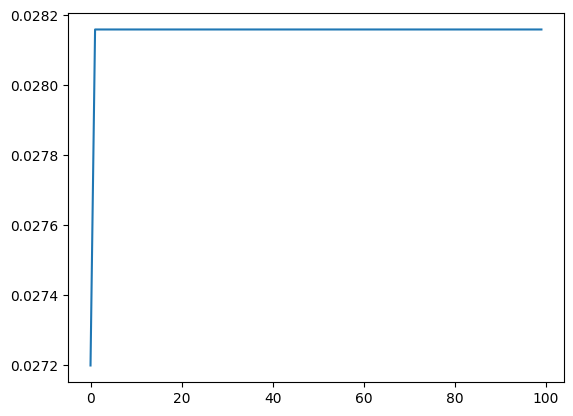

	 Testing subject 28 : acc 3.14%
	 Testing subject 26 : acc 2.79%
	 Testing subject 23 : acc 3.02%
	 Testing subject 6 : acc 2.80%
	 Testing subject 15 : acc 3.25%
	 Testing subject 33 : acc 3.32%
	 Testing subject 39 : acc 3.14%
	 Testing subject 4 : acc 2.76%
	 Testing subject 14 : acc 2.98%
	 Testing subject 3 : acc 2.82%
	 Testing subject 16 : acc 2.95%
	 Testing subject 29 : acc 3.12%
	 Testing subject 17 : acc 2.91%
	 Testing subject 13 : acc 3.20%
	 Testing subject 9 : acc 2.97%
	 Testing subject 20 : acc 2.87%
	 Testing subject 38 : acc 2.69%
	 Testing subject 11 : acc 2.81%
	 Testing subject 25 : acc 3.10%
Testing subject 28


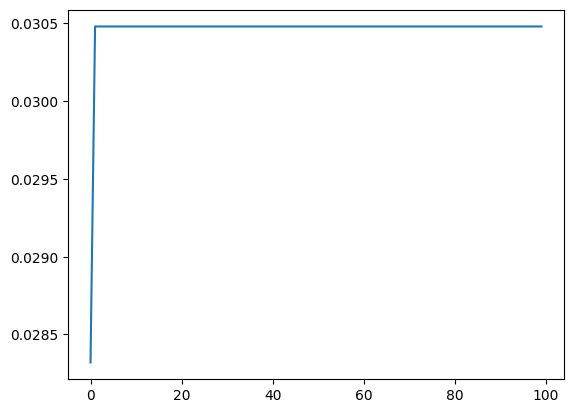

	 Testing subject 35 : acc 3.01%
	 Testing subject 26 : acc 3.17%
	 Testing subject 23 : acc 3.19%
	 Testing subject 6 : acc 2.75%
	 Testing subject 15 : acc 3.43%
	 Testing subject 33 : acc 3.45%
	 Testing subject 39 : acc 3.06%
	 Testing subject 4 : acc 2.98%
	 Testing subject 14 : acc 3.16%
	 Testing subject 3 : acc 2.82%
	 Testing subject 16 : acc 2.90%
	 Testing subject 29 : acc 2.52%
	 Testing subject 17 : acc 2.57%
	 Testing subject 13 : acc 2.98%
	 Testing subject 9 : acc 2.83%
	 Testing subject 20 : acc 3.20%
	 Testing subject 38 : acc 2.88%
	 Testing subject 11 : acc 2.80%
	 Testing subject 25 : acc 2.96%
Testing subject 26


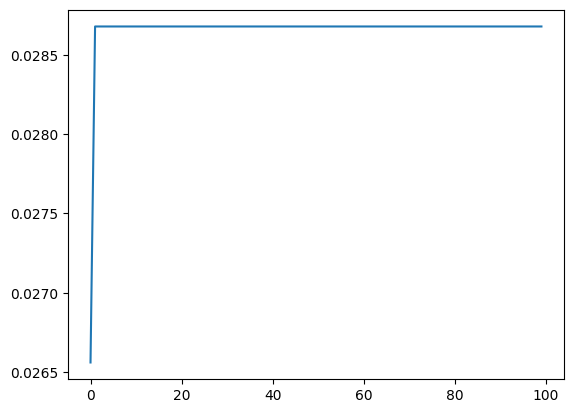

	 Testing subject 35 : acc 3.13%
	 Testing subject 28 : acc 3.11%
	 Testing subject 23 : acc 2.65%
	 Testing subject 6 : acc 2.85%
	 Testing subject 15 : acc 3.03%
	 Testing subject 33 : acc 3.24%
	 Testing subject 39 : acc 2.88%
	 Testing subject 4 : acc 2.93%
	 Testing subject 14 : acc 3.19%
	 Testing subject 3 : acc 2.88%
	 Testing subject 16 : acc 3.06%
	 Testing subject 29 : acc 2.85%
	 Testing subject 17 : acc 2.95%
	 Testing subject 13 : acc 2.94%


KeyboardInterrupt: 

In [16]:
Data_name = "DB2"
F = 2

Sub_all = []

for train_subject in sub_lst:
    print(f"Testing subject {train_subject}")
    X_train, y_train = ready_data_per_subject_all_reps(subject=train_subject, Data=Data_name, downsample=True, downsample_size=25000, feat_idx=F)

    model = Model.build_model_1D(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_train)))
    history = model.fit(X_train, y_train, epochs=100, batch_size=256, verbose=0)
    plt.plot(history.history['accuracy'])
    plt.show()

    Sub_acc = []
    for test_subject in sub_lst:
        if test_subject != train_subject:
            X_test, y_test = ready_data_per_subject_all_reps(subject=test_subject, Data=Data_name, downsample=True, downsample_size=10000, feat_idx=F)
            loss, acc = model.evaluate(X_test, y_test, verbose=0)
            print(f"\t Testing subject {test_subject} : acc {acc*100:.2f}%")
            Sub_acc.append(acc)
        else:
            continue
    Sub_all.append(Sub_acc)

In [11]:
Sub_all

[[0.027699999511241913,
  0.02879999950528145,
  0.025599999353289604,
  0.030400000512599945,
  0.03180000185966492,
  0.031099999323487282,
  0.02800000086426735,
  0.03009999915957451,
  0.031300000846385956,
  0.03240000084042549,
  0.028300000354647636,
  0.03099999949336052,
  0.027699999511241913,
  0.02930000051856041,
  0.027799999341368675,
  0.02889999933540821,
  0.028200000524520874,
  0.031700000166893005,
  0.03200000151991844],
 [0.030899999663233757,
  0.027499999850988388,
  0.02590000070631504,
  0.03009999915957451,
  0.030300000682473183,
  0.0284000001847744,
  0.02669999934732914,
  0.029600000008940697,
  0.02710000053048134,
  0.02850000001490116,
  0.030899999663233757,
  0.03099999949336052,
  0.031300000846385956,
  0.030799999833106995,
  0.029100000858306885,
  0.03009999915957451,
  0.028300000354647636,
  0.029100000858306885,
  0.032099999487400055],
 [0.027400000020861626,
  0.027799999341368675,
  0.02850000001490116,
  0.03200000151991844,
  0.029400

In [12]:
baseline = pd.DataFrame(Sub_all)
baseline.shape

(20, 19)

In [13]:
baseline.to_csv('./DB2_baseline.csv', index=False)

# Inter-subject incremental

In [14]:
Data_name = "DB2"
Sub_all = []

for test_subject in sub_lst:
    print(f"Testing subject {test_subject}")
    X_test, y_test = ready_data_per_subject_all_reps(subject=test_subject, Data=Data_name, downsample=True, downsample_size=10000, feat_idx=1)

    Sub_acc, X_train, y_train = [], [], []
    for train_subject in sub_lst:
        if train_subject != test_subject:
            X_train_tmp, y_train_tmp = ready_data_per_subject_all_reps(subject=train_subject, Data=Data_name, downsample=True, downsample_size=25000, feat_idx=1)
            X_train.append(X_train_tmp)
            y_train.append(y_train_tmp)

            X_train_arr, y_train_arr = np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)
            print("\t", X_train_arr.shape, y_train_arr.shape)

            model = Model.build_model_1D(input_shape=X_train_arr.shape[1:], num_classes=len(np.unique(y_train_arr)))
            model.fit(X_train_arr, y_train_arr, epochs=100, batch_size=256, verbose=0)
            loss, acc = model.evaluate(X_test, y_test, verbose=0)
            print(f"\t Added subject {train_subject} : acc {acc*100:.2f}%")
            Sub_acc.append(acc)

    Sub_all.append(Sub_acc)

Testing subject 35
	 (25000, 12, 1) (25000,)
	 Added subject 28 : acc 2.92%
	 (50000, 12, 1) (50000,)
	 Added subject 26 : acc 2.92%
	 (75000, 12, 1) (75000,)
	 Added subject 23 : acc 2.92%
	 (100000, 12, 1) (100000,)
	 Added subject 6 : acc 2.92%
	 (125000, 12, 1) (125000,)
	 Added subject 15 : acc 2.92%
	 (150000, 12, 1) (150000,)
	 Added subject 33 : acc 2.92%
	 (175000, 12, 1) (175000,)
	 Added subject 39 : acc 2.92%
	 (200000, 12, 1) (200000,)
	 Added subject 4 : acc 2.92%
	 (225000, 12, 1) (225000,)
	 Added subject 14 : acc 2.92%
	 (250000, 12, 1) (250000,)
	 Added subject 3 : acc 2.92%
	 (275000, 12, 1) (275000,)
	 Added subject 16 : acc 5.82%
	 (300000, 12, 1) (300000,)
	 Added subject 29 : acc 2.92%
	 (325000, 12, 1) (325000,)
	 Added subject 17 : acc 2.92%
	 (350000, 12, 1) (350000,)
	 Added subject 13 : acc 2.92%
	 (375000, 12, 1) (375000,)
	 Added subject 9 : acc 2.92%
	 (400000, 12, 1) (400000,)
	 Added subject 20 : acc 6.74%
	 (425000, 12, 1) (425000,)
	 Added subject 38 


KeyboardInterrupt



In [ ]:
acccc = pd.DataFrame(Sub_all)
acccc.to_csv('./DB2_inter_sub_accumulate.csv', index=False)
acccc.shape

# Few-shot adaptation